# Data Cleaning


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

df = pd.read_csv('7282_1.csv')
## Rename columns 
df.rename(columns = {'reviews.rating':'ratings', 'reviews.text':'reviews','reviews.username':'username'}, inplace = True)

## drop null values
df.dropna(subset=['ratings'], inplace=True)
df.dropna(subset=['reviews'], inplace=True)

## drop duplicates
df.drop_duplicates(subset=['username'])
df.dropna(subset=['ratings'], inplace=True)

## drop row 98 that has an invalid review "xxxxxxxxxxxxxxx"
df.drop(98, inplace=True)

df.reset_index(drop=True, inplace = True)

## standardize the ratings
filtered_values = df.loc[df['ratings'] > 5, 'ratings']
# Divide the filtered values by 2
filtered_values_divided = filtered_values / 2
# Update the original DataFrame with the new values
df.loc[df['ratings'] > 5, 'ratings'] = filtered_values_divided


## categorizing ratings
df.loc[(df['ratings'] >= 4.5), 'ratings'] = 5.0

df.loc[(df['ratings'] >= 3.5) & (df['ratings'] < 4.5), 'ratings'] = 4.0

df.loc[(df['ratings'] >= 2.5) & (df['ratings'] < 3.5), 'ratings'] = 3.0

df.loc[(df['ratings'] >= 1.5) & (df['ratings'] < 2.5), 'ratings'] = 2.0

df.loc[(df['ratings'] >= 0.5) & (df['ratings'] < 1.5), 'ratings'] = 1.0

df.loc[(df['ratings'] < 0.5), 'ratings'] = 0.0

## sentiment mask based on ratings 
df['sentiment'] = df['ratings'].map({0:'negative', 1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5:'positive'})
df = df[['reviews', 'sentiment']]

## drop all rows where sentiment is neutral
df.drop(df[df['sentiment'] =='neutral'].index, inplace=True)

#converting labels to 0 and 1
df['sentiment'] = df['sentiment'].map({'negative':0, 'positive':1})



# Preprocessing data

In [3]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_Stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    return " ".join(words)

#change word back to its original form
def lemmatize_text(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words]
        wordlist.append(" ".join(words))
    return " ".join(wordlist)

#remove special characters and punctuations from the text
def clean_text(text):
    delete_dic = {sp_character: "" for sp_character in string.punctuation}
    delete_dic[" "] = " "
    table = str.maketrans(delete_dic)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = " ".join([word for word in textArr])
    return text2.lower()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymanadil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aymanadil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aymanadil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Cleaned data 

In [4]:
df['reviews'] = df['reviews'].apply(clean_text)
df['reviews'] = df['reviews'].apply(remove_Stopwords)
df['reviews'] = df['reviews'].apply(lemmatize_text)

# negative_df = df[df['sentiment'] == 'negative']
# negative_df.head(10)

In [5]:
# df.drop(df[df['sentiment'] == 'neutral'].index, inplace=True)

df.shape

(29243, 2)

# Splitting data

In [6]:
from sklearn.model_selection import train_test_split
X = df['reviews']
y = df['sentiment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(23394,) (23394,)
(5849,) (5849,)


# Preparing embedding layer

In [8]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

word_tokenize = Tokenizer()
word_tokenize.fit_on_texts(X_train)

X_train = word_tokenize.texts_to_sequences(X_train)
X_test = word_tokenize.texts_to_sequences(X_test)

vocab_size = len(word_tokenize.word_index) + 1
maxlen = max([len(x) for x in X_train])
print(maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


289


### Creating feature matrix using GloVe word embeddings

In [9]:
from numpy import asarray
from numpy import zeros

In [10]:
embeddings_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions

glove_file.close()

# Creating embedding matrix 
this will contain 100 dimentional GloVe word embeddings for all words 
in our corpus

In [11]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in word_tokenize.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(28258, 100)

# Creating a Simple Neural Network

In [12]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = maxlen, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

#### Model compiling

In [13]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 289, 100)          2825800   
                                                                 
 flatten (Flatten)           (None, 28900)             0         
                                                                 
 dense (Dense)               (None, 1)                 28901     
                                                                 
Total params: 2854701 (10.89 MB)
Trainable params: 28901 (112.89 KB)
Non-trainable params: 2825800 (10.78 MB)
_________________________________________________________________
None


#### Model Training

In [15]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
147/147 [==============================] - 0s 2ms/step - loss: 0.3931 - acc: 0.8301 - val_loss: 0.3339 - val_acc: 0.8532
Epoch 2/6
147/147 [==============================] - 0s 2ms/step - loss: 0.2996 - acc: 0.8749 - val_loss: 0.3137 - val_acc: 0.8626
Epoch 3/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2716 - acc: 0.8868 - val_loss: 0.3080 - val_acc: 0.8679
Epoch 4/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2559 - acc: 0.8963 - val_loss: 0.3083 - val_acc: 0.8671
Epoch 5/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2449 - acc: 0.9015 - val_loss: 0.3081 - val_acc: 0.8724
Epoch 6/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2374 - acc: 0.9044 - val_loss: 0.3104 - val_acc: 0.8733


#### Predictions on test set

In [17]:
score = snn_model.evaluate(X_test, y_test, verbose=1)
print("test set score: ", score[0])
print("test set accuracy: ", score[1])

183/183 [==============================] - 0s 893us/step - loss: 0.3147 - acc: 0.8713
test set score:  0.3146629333496094
test set accuracy:  0.8712600469589233


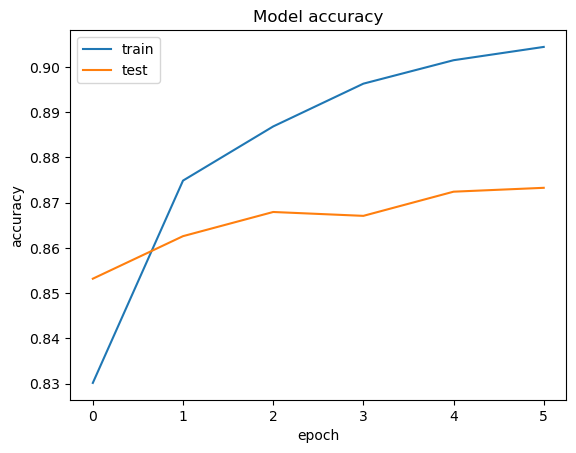

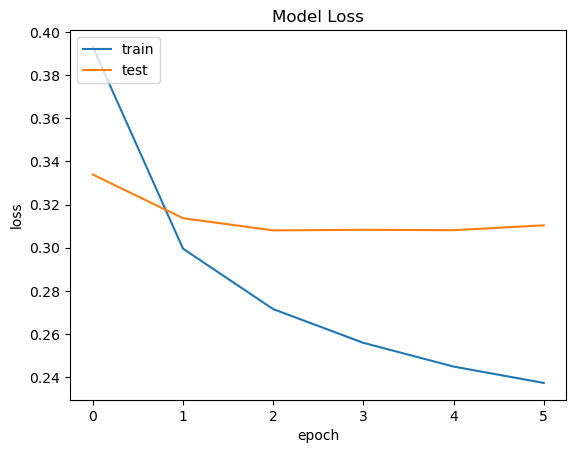

In [20]:
# Plotting charts for performance
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Analysis
we can clearly see that some overfitting has taken place, our training accuracy is much higher than our testing accuracy 

# Creating a Convolutional Neural Net

In [21]:
from keras.layers import Conv1D

In [23]:
# Basic architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [24]:
# Model compiling 

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 289, 100)          2825800   
                                                                 
 conv1d_1 (Conv1D)           (None, 285, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2890057 (11.02 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 2825800 (10.78 MB)
_________________________________________________________________
None


#### Training  convolutional net

In [25]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
147/147 [==============================] - 5s 32ms/step - loss: 0.3224 - acc: 0.8644 - val_loss: 0.2857 - val_acc: 0.8842
Epoch 2/6
147/147 [==============================] - 5s 32ms/step - loss: 0.2459 - acc: 0.9023 - val_loss: 0.2673 - val_acc: 0.8925
Epoch 3/6
147/147 [==============================] - 5s 32ms/step - loss: 0.2078 - acc: 0.9224 - val_loss: 0.2585 - val_acc: 0.8974
Epoch 4/6
147/147 [==============================] - 5s 32ms/step - loss: 0.1766 - acc: 0.9351 - val_loss: 0.2610 - val_acc: 0.8966
Epoch 5/6
147/147 [==============================] - 5s 32ms/step - loss: 0.1481 - acc: 0.9498 - val_loss: 0.2583 - val_acc: 0.8996
Epoch 6/6
147/147 [==============================] - 5s 32ms/step - loss: 0.1216 - acc: 0.9629 - val_loss: 0.2792 - val_acc: 0.8861


In [26]:
print('Convolutional net score: ', score[0])
print('Convolutional net loss: ', score[1])

Convolutional net score:  0.3146629333496094
Convolutional net loss:  0.8712600469589233


#### Convolutional Net Performance Charts

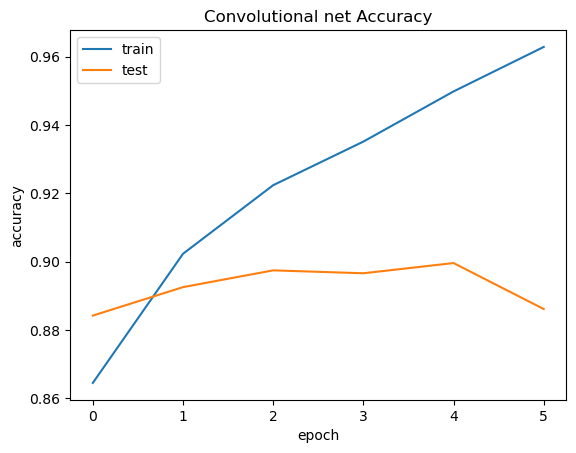

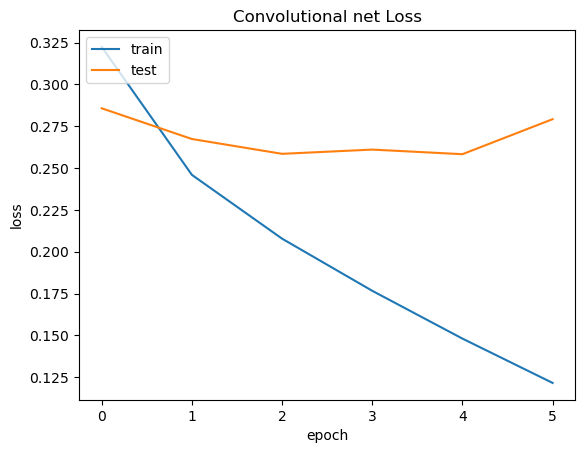

In [28]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Convolutional net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Convolutional net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()